##ECE M214A Project: Speaker Region Identification



In this project, we'll train a machine learning algorithm to classify speakers by regional dialect.  We will use speech samples from the Corpus of Regional African American Language (CORAAL - https://oraal.github.io/coraal) with speakers each belonging to one of six different US cities: 1) Rochester, NY (ROC), 2) Lower East Side, Manhattan, NY (LES), 3) Washington DC (DCB), 4) Princeville, NC (PRV), 5) Valdosta, GA (VLD) or 6) Detroit, MI (DTA)

The project files can be downloaded from [this link](https://ucla.box.com/s/mohh4fnmgj3vekui8i8n28i02odleaop)

To do this, we will first extract features from the audio files and then train a classifier to predict the city of origin of the utterance's speaker.  The goal is to extract a feature that contains useful information about regional dialect characteristics.

##1. Setting up the data directories and Google Colab

Store a copy of the project files in your google drive.

Make sure that the 'project_data' folder is stored in the top level of your google drive. Otherwise, you will need to change the corresponding paths in the remainder of the notebook.

Mount your google drive. This will give this notebook read/write access to data stored in your google drive.  You can either do this in the file browser on the left side of this notebook or by running the code snippet below.

It is recommended that you use your UCLA google account for this project, as it has more storage than a standard google account.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To run this project on your local system, replace the corresponding file paths to the locations of the project files on your local machine

# <span style="color:blue"> ***** </span><span style="color:red"> Execute only for Laptop Environment</span> <span style="color:blue"> ***** </span>
<span style="color:white"> <h3>  ****   Execute the next cell if the plan is to run the code in laptop environment</span> 

In [1]:
import sys, os
parent_dir = os.path.dirname(os.path.realpath('/Users/akpy27/Downloads/ucla-ece-m214a-project-sri'))

# <span style="color:red"> ***** </span><span style="color:blue"> Execute all the cells from this point for all environment</span> <span style="color:green"> ***** </span>

In [3]:
# To get one directory up from the current file
project_dir = os.path.abspath(os.path.join(parent_dir, "./Untitled/"))

sys.path.insert(0,project_dir)

print ('Parent Directory Path:', parent_dir)
print ('Project Path:', project_dir)

Parent Directory Path: /Users/akpy27/Downloads
Project Path: /Users/akpy27/Downloads/Untitled


## 2. Getting familiar with the data


Let's take a moment to understand the data.  The original CORAAL dataset consists of speakersfrom one of seven cities split into 8 components.  The audio files are names with the convention: DCB_se1_ag1_f_03.  Here, DCB is the city code, se1 denotes the socioeconomic group of the speaker, ag1 denotes the age group of the speaker, f denotes female, and 03 denotes the participant number.  These unique combinations of identifiers mark the speaker.  

The dataset has been preprocessed to only include audio segments greater than 5 seconds in length. Those segments are numbered with the appending tag _{seg_number} for each segment.

You can also try listening to any segment like this:

In [4]:
from IPython.display import Audio

sr = 44100

Audio(filename= project_dir + "/project_data/train/DCB_se1_ag2_m_01_1_11.wav", rate=sr)

The original dataset has also been split into a train and test set. The test set has been further split, with a portion corrupted with the addition of noise:

In [ ]:
sr = 44100

Audio(filename= "drive/MyDrive/project_data/test_clean/ROC_se0_ag2_f_01_1_396.wav", rate=sr)

In [ ]:
sr = 44100

Audio(filename= "drive/MyDrive/project_data/test_noisy/VLD_se0_ag4_m_02_1_64.wav", rate=sr)

## 3. Feature Extraction

As a baseline, we will be using the average mfcc value over time from the Librosa Python library. Your job will be to choose better features to improve performance on both the clean and noisy data

We first define a pair of functions to create features and labels for our classification model:


In [5]:
import librosa
import torchaudio
import numpy as np
from glob import glob
from tqdm import tqdm


def extract_feature(audio_file, n_mfcc=13, preprocess=False):

  '''
  Function to extract features from a single audio file given its path
  Modify this function to extract your own custom features
  '''

  audio,fs = torchaudio.load(audio_file)
  audio = audio.numpy().reshape(-1)

  if preprocess:
    #write code to do preprocessing - scipy, librosa
    audio = librosa.resample(audio, orig_sr=44100, target_sr=16000)

  # replace the following features with your own - audiomentations, spafe
  mfccs = librosa.feature.mfcc(y=audio, sr=fs, n_mfcc=n_mfcc)
  delta1 = mfccs[:-1] - mfccs[1:]
  delta2 = delta1[:-1] - delta1[1:]

  mfccs = np.concatenate((mfccs, delta1, delta2))
  #gtcc (gfcc), pncc
  #whitening filter, spectral gating filter
  feat_out = np.mean(mfccs,axis=1)

  return feat_out


def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DCB' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  elif 'DTA' in file_name:
    label=5
  else:
    raise ValueError('invalid file name')
  return label

Let us now call these functions to extract the features and labels from the train directory

In [6]:

#First we obtain the list of all files in the train directory
train_files = glob(project_dir + "/project_data/train/*.wav")

#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort()

train_feat=[]
train_label=[]

for wav in tqdm(train_files):

  train_feat.append(extract_feature(wav))
  train_label.append(get_label(wav))

100%|██████████| 8980/8980 [01:50<00:00, 81.32it/s] 


In [7]:
#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob(project_dir + '/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort()

test_clean_feat=[]
test_clean_label=[]

for wav in tqdm(test_clean_files):

  test_clean_feat.append(extract_feature(wav))
  test_clean_label.append(get_label(wav))

100%|██████████| 2533/2533 [00:30<00:00, 83.59it/s]


In [8]:
#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob(project_dir + '/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort()

test_noisy_feat=[]
test_noisy_label=[]

for wav in tqdm(test_noisy_files):

  test_noisy_feat.append(extract_feature(wav))
  test_noisy_label.append(get_label(wav))

100%|██████████| 3238/3238 [00:38<00:00, 83.14it/s]


## 4. Model Training and Predictions

Now we'll train the backend system to predict the regions from the input features.  We'll use an xgboosted decision tree for this.  An advantage of this model is that we can also parse the decision tree and measure the impact of different features in the end result for explainability

In [9]:
#Install shap library
!pip install shap

In [10]:
import xgboost
import numpy as np
import shap
import pandas as pd

#Format input data

#Edit this variable to create a list that contains your feature names
feat_names=['mfcc_' +str(n) for n in range(len(train_feat[0]))]

train_feat_df = pd.DataFrame(data=np.stack(train_feat), columns=feat_names)
y_train=np.stack(train_label)


test_clean_feat_df = pd.DataFrame(data=np.stack(test_clean_feat), columns=feat_names)
y_test_clean=np.stack(test_clean_label)


test_noisy_feat_df = pd.DataFrame(data=np.stack(test_noisy_feat), columns=feat_names)
y_test_noisy=np.stack(test_noisy_label)


#you could just pass in the matrix of features to xgboost
#but it looks prettier in the shap explainer if you format it
#as a dataframe.


model = xgboost.XGBClassifier()
model.fit(train_feat_df,y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train Clean Acc = 1.0
Test Clean Acc = 0.518752467429925
Test Noisy Acc = 0.471278567016677


To save a dataframe of features, uncomment and run the following block of code

In [11]:
train_feat_df.to_csv(project_dir + '/project_data/current_features.csv' )
test_clean_feat_df.to_csv(project_dir + '/project_data/mfcc13_test_clean.csv')
test_noisy_feat_df.to_csv(project_dir + '/project_data/mfcc13_test_noisy.csv')

To Load a preexisting dataframe of features (saved from a previous notebook), run the following cell and then train the model

In [13]:
train_feat_df = pd.read_csv(project_dir + '/project_data/current_features.csv', index_col = 0)
test_clean_feat_df = pd.read_csv(project_dir + '/project_data/mfcc13_test_clean.csv', index_col = 0)
test_noisy_feat_df = pd.read_csv(project_dir + '/project_data/mfcc13_test_noisy.csv', index_col = 0)

## 5. Interpreting Results and Explainability

To see the impact different features have on the model, we create a plot of the feature importances. The features are listed top to bottom in order of how important they were to the decision.

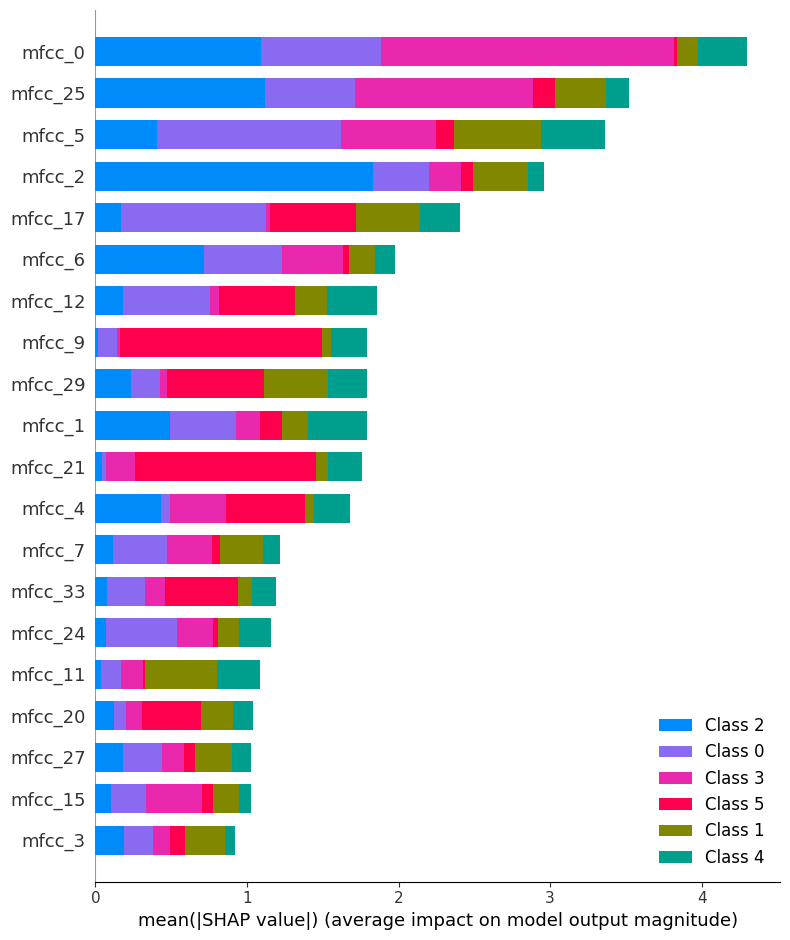

In [14]:
import shap

# Explain the model's predictions using SHAP by computing SHAP values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(train_feat_df)

#Convert the shap values for each class to a single list
shap_as_list=[]
for i in range(6):
    shap_as_list.append(shap_values[:,:,i])

# Plot the SHAP values
shap.summary_plot(shap_as_list, train_feat_df, plot_type="bar")

And we can see a confusion matrix of the mispredictions

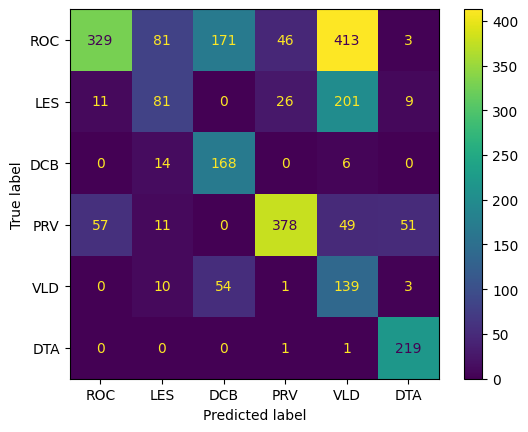

In [15]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, model.predict(test_clean_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD', 'DTA'])
cm_display.plot()
plt.show()



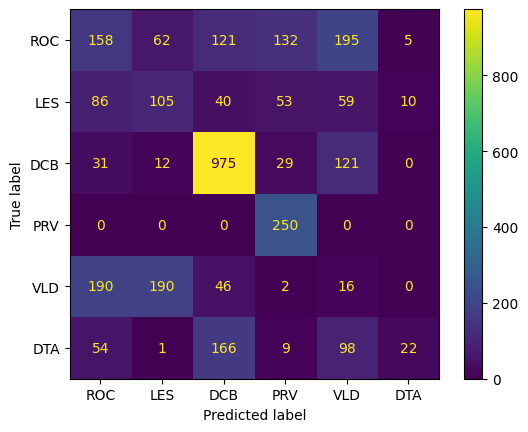

In [16]:

confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, model.predict(test_noisy_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD', 'DTA'])
cm_display.plot()
plt.show()

# 6. We now repeat this with resampling

In [17]:
train_feat_rs=[]

for wav in tqdm(train_files):

  train_feat_rs.append(extract_feature(wav, preprocess=True))

100%|██████████| 8980/8980 [01:26<00:00, 103.38it/s]


In [18]:
test_clean_feat_rs = []

for wav in tqdm(test_clean_files):

  test_clean_feat_rs.append(extract_feature(wav, preprocess=True))

100%|██████████| 2533/2533 [00:19<00:00, 129.86it/s]


In [19]:
test_noisy_feat_rs = []

for wav in tqdm(test_noisy_files):

  test_noisy_feat_rs.append(extract_feature(wav, preprocess=True))

100%|██████████| 3238/3238 [00:26<00:00, 124.47it/s]


In [20]:
train_feat_rs_df = pd.DataFrame(data=np.stack(train_feat_rs), columns=feat_names)

test_clean_feat_rs_df = pd.DataFrame(data=np.stack(test_clean_feat_rs), columns=feat_names)

test_noisy_feat_rs_df = pd.DataFrame(data=np.stack(test_noisy_feat_rs), columns=feat_names)


model_rs = xgboost.XGBClassifier()
model_rs.fit(train_feat_rs_df,y_train)

print("Train Clean Resample Acc =", np.sum(y_train==model_rs.predict(train_feat_rs_df))/len(y_train))

print("Test Clean Resample Acc =", np.sum(y_test_clean==model_rs.predict(test_clean_feat_rs_df))/len(y_test_clean))

print("Test Noisy Resample Acc =", np.sum(y_test_noisy==model_rs.predict(test_noisy_feat_rs_df))/len(y_test_noisy))


Train Clean Resample Acc = 1.0
Test Clean Resample Acc = 0.3880773786024477
Test Noisy Resample Acc = 0.32643607164916616


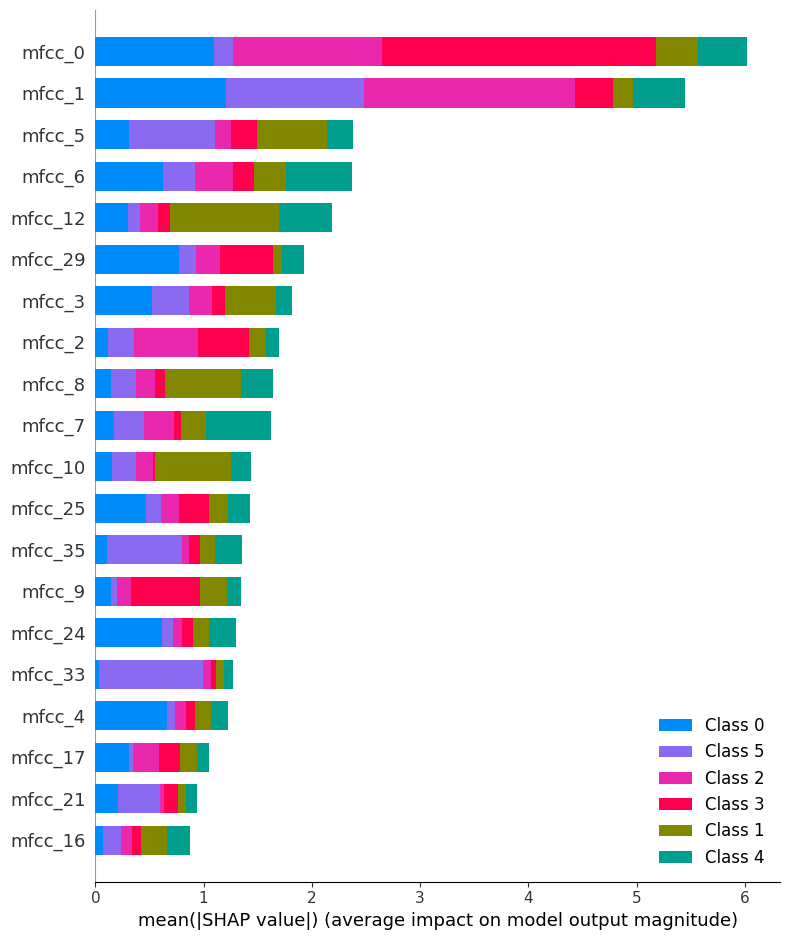

In [21]:
import shap

# Explain the model's predictions using SHAP by computing SHAP values
explainer = shap.Explainer(model_rs)
shap_values = explainer.shap_values(train_feat_rs_df)

#Convert the shap values for each class to a single list
shap_as_list=[]
for i in range(6):
    shap_as_list.append(shap_values[:,:,i])

# Plot the SHAP values
shap.summary_plot(shap_as_list, train_feat_rs_df, plot_type="bar")

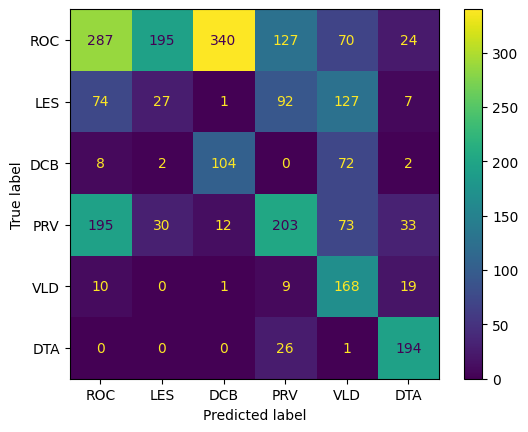

In [22]:
confusion_matrix_clean_rs = metrics.confusion_matrix(y_test_clean, model_rs.predict(test_clean_feat_rs_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean_rs, display_labels = ['ROC','LES','DCB','PRV','VLD', 'DTA'])
cm_display.plot()
plt.show()

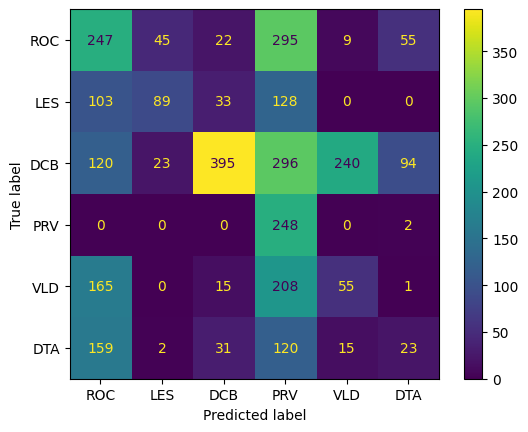

In [23]:
confusion_matrix_noisy_rs = metrics.confusion_matrix(y_test_noisy, model_rs.predict(test_noisy_feat_rs_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy_rs, display_labels = ['ROC','LES','DCB','PRV','VLD', 'DTA'])
cm_display.plot()
plt.show()

# 7. Using Opensmile

eGeMaps Feature Set:

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7160715

In [24]:
train_files = glob(project_dir + "/project_data/train/*.wav")
test_clean_files = glob(project_dir + '/project_data/test_clean/*.wav')
test_noisy_files = glob(project_dir + '/project_data/test_noisy/*.wav')

In [25]:
!pip install opensmile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.2/706.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.2 MB/s eta 0:00:00


In [26]:
import opensmile
smile = opensmile.Smile(
      feature_set=opensmile.FeatureSet.ComParE_2016,
      feature_level=opensmile.FeatureLevel.Functionals,
  )

len(smile.feature_names)

6373

In [27]:
smile.feature_names

['audspec_lengthL1norm_sma_range',
 'audspec_lengthL1norm_sma_maxPos',
 'audspec_lengthL1norm_sma_minPos',
 'audspec_lengthL1norm_sma_quartile1',
 'audspec_lengthL1norm_sma_quartile2',
 'audspec_lengthL1norm_sma_quartile3',
 'audspec_lengthL1norm_sma_iqr1-2',
 'audspec_lengthL1norm_sma_iqr2-3',
 'audspec_lengthL1norm_sma_iqr1-3',
 'audspec_lengthL1norm_sma_percentile1.0',
 'audspec_lengthL1norm_sma_percentile99.0',
 'audspec_lengthL1norm_sma_pctlrange0-1',
 'audspec_lengthL1norm_sma_stddev',
 'audspec_lengthL1norm_sma_skewness',
 'audspec_lengthL1norm_sma_kurtosis',
 'audspec_lengthL1norm_sma_meanSegLen',
 'audspec_lengthL1norm_sma_maxSegLen',
 'audspec_lengthL1norm_sma_minSegLen',
 'audspec_lengthL1norm_sma_segLenStddev',
 'audspec_lengthL1norm_sma_upleveltime25',
 'audspec_lengthL1norm_sma_upleveltime50',
 'audspec_lengthL1norm_sma_upleveltime75',
 'audspec_lengthL1norm_sma_upleveltime90',
 'audspec_lengthL1norm_sma_risetime',
 'audspec_lengthL1norm_sma_leftctime',
 'audspec_lengthL1

In [28]:
smile2 = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)
smile2.feature_names

['Loudness_sma3',
 'alphaRatio_sma3',
 'hammarbergIndex_sma3',
 'slope0-500_sma3',
 'slope500-1500_sma3',
 'spectralFlux_sma3',
 'mfcc1_sma3',
 'mfcc2_sma3',
 'mfcc3_sma3',
 'mfcc4_sma3',
 'F0semitoneFrom27.5Hz_sma3nz',
 'jitterLocal_sma3nz',
 'shimmerLocaldB_sma3nz',
 'HNRdBACF_sma3nz',
 'logRelF0-H1-H2_sma3nz',
 'logRelF0-H1-A3_sma3nz',
 'F1frequency_sma3nz',
 'F1bandwidth_sma3nz',
 'F1amplitudeLogRelF0_sma3nz',
 'F2frequency_sma3nz',
 'F2bandwidth_sma3nz',
 'F2amplitudeLogRelF0_sma3nz',
 'F3frequency_sma3nz',
 'F3bandwidth_sma3nz',
 'F3amplitudeLogRelF0_sma3nz']

In [29]:
len(smile2.feature_names)

25

In [30]:
import torchaudio
import numpy as np
def extract_smile(wav):

  audio,sample_fs = torchaudio.load(wav)

  sample_audio = audio.numpy().reshape(-1)

  smile = opensmile.Smile(
      feature_set=opensmile.FeatureSet.ComParE_2016,
      feature_level=opensmile.FeatureLevel.Functionals,
  )
  # opensmile.FeatureSet.GeMAPSv01b
  #opensmile.FeatureSet.ComParE_2016,
  #opensmile.FeatureSet.eGeMAPSv02
  y = smile.process_signal(
      sample_audio,
      sample_fs
  )
  return np.array(y.iloc[0])

In [33]:
wav = project_dir + "/project_data/train/DCB_se1_ag2_m_01_1_11.wav"

In [34]:
extract_smile(wav).shape

(6373,)

In [35]:
train_feat_os=[]
train_label = []

for wav in tqdm(train_files):

  train_feat_os.append(extract_smile(wav))
  train_label.append(get_label(wav))

100%|██████████| 8980/8980 [27:29<00:00,  5.44it/s]


In [36]:
test_clean_feat_os=[]
test_clean_label = []

for wav in tqdm(test_clean_files):

  test_clean_feat_os.append(extract_smile(wav))
  test_clean_label.append(get_label(wav))

100%|██████████| 2533/2533 [07:37<00:00,  5.54it/s]


In [37]:
test_noisy_feat_os = []
test_noisy_label = []

for wav in tqdm(test_noisy_files):

  test_noisy_feat_os.append(extract_smile(wav))
  test_noisy_label.append(get_label(wav))

100%|██████████| 3238/3238 [10:15<00:00,  5.26it/s]


In [38]:
feat_names_os  = list(smile.feature_names)

In [39]:
import re

def remove_non_alphanumeric(feat_names_os):
    """
    Remove all non-alphanumeric characters from entries in feat_names_os.

    Args:
        feat_names_os (list of str): List of feature names.

    Returns:
        list of str: List of cleaned feature names.
    """
    cleaned_feat_names = [re.sub(r'\W+', '', name) for name in feat_names_os]
    return cleaned_feat_names

feat_names_os = remove_non_alphanumeric(feat_names_os)

In [40]:
import pandas as pd
import xgboost
import numpy as np

train_feat_os_df = pd.DataFrame(data=np.stack(train_feat_os), columns=feat_names_os)
y_train=np.stack(train_label)

test_clean_feat_os_df = pd.DataFrame(data=np.stack(test_clean_feat_os), columns=feat_names_os)
y_test_clean=np.stack(test_clean_label)

test_noisy_feat_os_df = pd.DataFrame(data=np.stack(test_noisy_feat_os), columns=feat_names_os)
y_test_noisy=np.stack(test_noisy_label)

model_os = xgboost.XGBClassifier()
model_os.fit(train_feat_os_df,y_train)

print("Train Clean Opensmile Acc =", np.sum(y_train==model_os.predict(train_feat_os_df))/len(y_train))

print("Test Clean Opensmile Acc =", np.sum(y_test_clean==model_os.predict(test_clean_feat_os_df))/len(y_test_clean))

print("Test Noisy Opensmile Acc =", np.sum(y_test_noisy==model_os.predict(test_noisy_feat_os_df))/len(y_test_noisy))


Train Clean Opensmile Acc = 1.0
Test Clean Opensmile Acc = 0.6221871298855113
Test Noisy Opensmile Acc = 0.5799876466954911


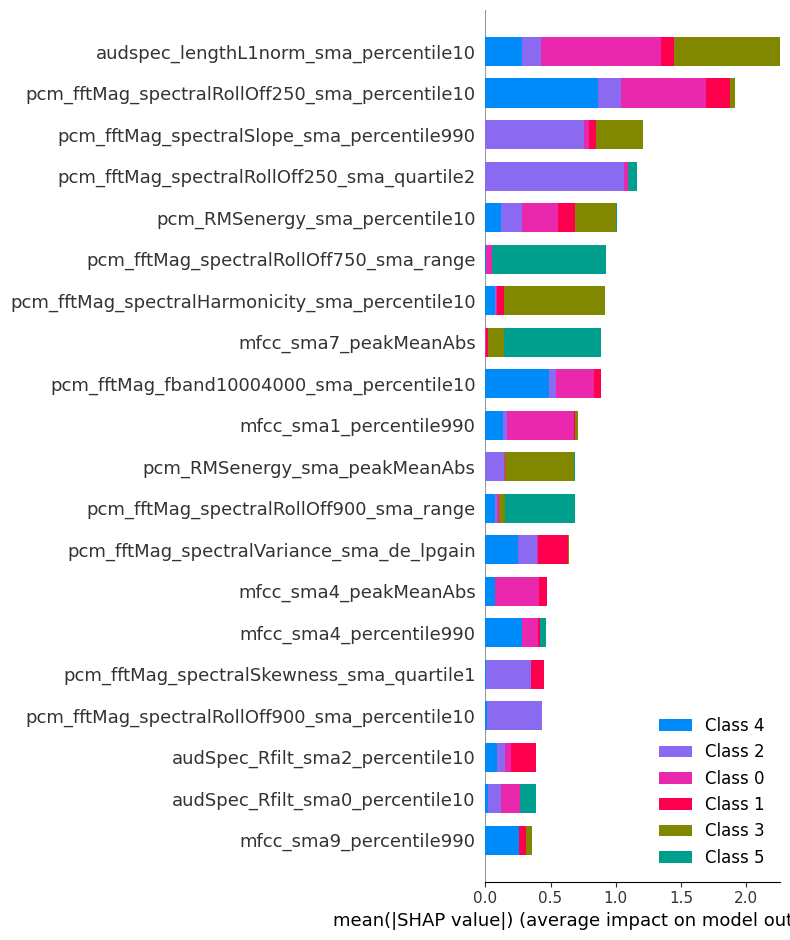

In [41]:
import shap

# Explain the model's predictions using SHAP by computing SHAP values
explainer = shap.Explainer(model_os)
shap_values = explainer.shap_values(train_feat_os_df)

#Convert the shap values for each class to a single list
shap_as_list=[]
for i in range(6):
    shap_as_list.append(shap_values[:,:,i])

# Plot the SHAP values
shap.summary_plot(shap_as_list, train_feat_os_df, plot_type="bar")

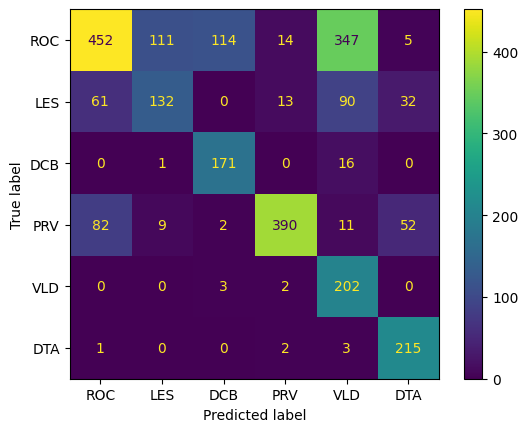

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
confusion_matrix_clean_os = metrics.confusion_matrix(y_test_clean, model_os.predict(test_clean_feat_os_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean_os, display_labels = ['ROC','LES','DCB','PRV','VLD', 'DTA'])
cm_display.plot()
plt.show()

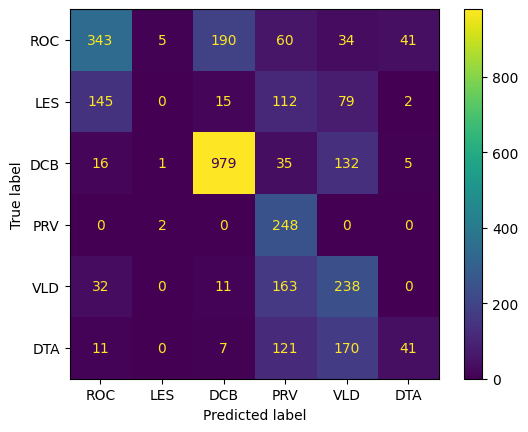

In [ ]:
confusion_matrix_noisy_os = metrics.confusion_matrix(y_test_noisy, model_os.predict(test_noisy_feat_os_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy_os, display_labels = ['ROC','LES','DCB','PRV','VLD', 'DTA'])
cm_display.plot()
plt.show()

In [42]:
train_feat_os_df.to_csv('drive/MyDrive/features/os_train.csv')
test_clean_feat_os_df.to_csv('drive/MyDrive/features/os_test_clean.csv')
test_noisy_feat_os_df.to_csv('drive/MyDrive/features/os_test_noisy.csv')

OSError: Cannot save file into a non-existent directory: 'drive/MyDrive/features'

#9. Combining Multiple features

In [ ]:
import xgboost
import numpy as np
import shap
import pandas as pd

feature_name1 = "mfcc13"
feature_name2 = "os"

save_directory = 'drive/MyDrive/features'

#load csv
train_feat1_df = pd.read_csv(f'{save_directory}/{feature_name1}_train.csv', index_col=0)
test_clean_feat1_df = pd.read_csv(f'{save_directory}/{feature_name1}_test_clean.csv', index_col=0)
test_noisy_feat1_df = pd.read_csv(f'{save_directory}/{feature_name1}_test_noisy.csv', index_col=0)

train_feat2_df = pd.read_csv(f'{save_directory}/{feature_name2}_train.csv', index_col=0)
test_clean_feat2_df = pd.read_csv(f'{save_directory}/{feature_name2}_test_clean.csv', index_col=0)
test_noisy_feat2_df = pd.read_csv(f'{save_directory}/{feature_name2}_test_noisy.csv', index_col=0)

train_feat_df = pd.concat([train_feat1_df, train_feat2_df], axis=1)
test_clean_feat_df = pd.concat([test_clean_feat1_df, test_clean_feat2_df], axis=1)
test_noisy_feat_df = pd.concat([test_noisy_feat1_df, test_noisy_feat2_df], axis=1)


feat_names=['mfcc_' +str(n) for n in range(13)]
feat_names+=list(smile.feature_names)

y_train=np.stack(train_label)
y_test_clean=np.stack(test_clean_label)
y_test_noisy=np.stack(test_noisy_label)

In [ ]:
model = xgboost.XGBClassifier()
model.fit(train_feat_df,y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))

Train Clean Acc = 1.0
Test Clean Acc = 0.6131069877615476
Test Noisy Acc = 0.5667078443483632


#Other features that may be useful:

- PNCC

- PLP

- GTCC

- i-vectors

# Using speaker embeddings

In [ ]:
!pip install speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 38.9 MB/s eta 0:00:00


In [ ]:
import librosa
import torch
from speechbrain.inference.speaker import EncoderClassifier
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")
#ivectors, xvctors, or ecapa tdnn vectors


hyperparams.yaml:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

In [ ]:
wav = "drive/MyDrive/project_data/train/DCB_se1_ag2_m_01_1_11.wav"

In [ ]:
audio, sample_rate = librosa.load(wav, sr=16000)

# Compute speaker embedding for the segment
signal = torch.tensor(audio).unsqueeze(0)  # Add batch dimension
embedding = classifier.encode_batch(signal)

embedding = embedding.detach().numpy().squeeze()

# Now you have a single mean speaker embedding
print(embedding.shape)

(192,)
